# [IAPR 2020:][iapr2020] Lab 2 ‒  Object description

**Authors:** Dhruti_Shah, Mahdi_Nobar, Zahra_Farsijani 
**Due date:** 24.04.2020

[iapr2020]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

In [2]:
from skimage import measure, transform, morphology
import numpy as np
from sklearn.manifold import TSNE
import cv2
import math
from sklearn.decomposition import PCA
from scipy import ndimage
from skimage.morphology import medial_axis, skeletonize

## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

### 1.1 Data visualization

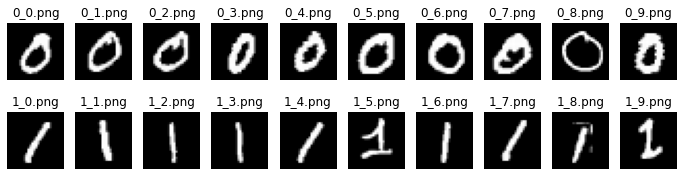

In [3]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load images
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
#  Load zeros
zeros_path = os.path.join(data_base_path, data_folder, 'part1', '0')
zeros_names = [nm for nm in os.listdir(zeros_path) if '.png' in nm]  # make sure to only load .png
zeros_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(zeros_path, nm) for nm in zeros_names])
zeros_im = skimage.io.concatenate_images(ic)
#  Load ones
ones_path = os.path.join(data_base_path, data_folder, 'part1', '1')
ones_names = [nm for nm in os.listdir(ones_path) if '.png' in nm]  # make sure to only load .png
ones_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(ones_path, nm) for nm in ones_names]))
ones_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2 Fourier descriptors
The idea behind fourier descriptors is as follows:

For $(x_k, y_k)$ as $N$ successive points of the contour of the object we are interested in, we define each of these points as a complex number : $u_k = x_k + jy_k$.

We then take a $N$ point DFT of these points and what we get are the fourier descriptors of the image.
The fourier transform of the contours gives a decomposition in frequencies.

As the first step to obtain the fourier descriptors, we would like to pre-process the image, and then find the contour corresponding to the digit.

For pre-processing, we first do a thresholding, so that we now have a binary image, instead of s grayscale one. Next, we do a binary-opening. We do this because there might be other small noise present in the image apart from the digit, which we are not interested in. So a binary opening will get rid of these smaller artefacts.

Next, we do a contour detection, and consider the largest contour. This is because in our image, the digi of interest will correspond to the largest contour.

In [4]:
def pre_process(im):
    return morphology.binary_opening(im>5, np.ones([2,2]))

In [5]:
def get_contour(im):
    contours = measure.find_contours(im,0)
    contours.sort(key = lambda c: c.shape[0], reverse=True)
    return contours[0]

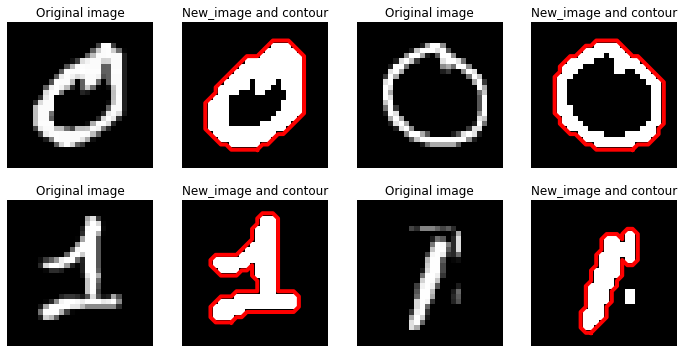

In [6]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

axes[0][0].imshow(zeros_im[2], cmap='gray')
axes[0][0].set_title('Original image')
axes[0][0].axis('off')
axes[0][1].imshow(pre_process(zeros_im[2]), cmap='gray')
axes[0][1].set_title('New_image and contour')
axes[0][1].axis('off')
c = get_contour(pre_process(zeros_im[2]))
axes[0][1].plot(c[:,1],c[:,0], color ='red', linewidth=4)

axes[0][2].imshow(zeros_im[8], cmap='gray')
axes[0][2].set_title('Original image')
axes[0][2].axis('off')
axes[0][3].imshow(pre_process(zeros_im[8]), cmap='gray')
axes[0][3].set_title('New_image and contour')
axes[0][3].axis('off')
c = get_contour(pre_process(zeros_im[8]))
axes[0][3].plot(c[:,1],c[:,0], color ='red', linewidth=4)

axes[1][0].imshow(ones_im[5], cmap='gray')
axes[1][0].set_title('Original image')
axes[1][0].axis('off')
axes[1][1].imshow(pre_process(ones_im[5]), cmap='gray')
axes[1][1].set_title('New_image and contour')
axes[1][1].axis('off')
c = get_contour(pre_process(ones_im[5]))
axes[1][1].plot(c[:,1],c[:,0], color ='red', linewidth=4)

axes[1][2].imshow(ones_im[8], cmap='gray')
axes[1][2].set_title('Original image')
axes[1][2].axis('off')
axes[1][3].imshow(pre_process(ones_im[8]), cmap='gray')
axes[1][3].set_title('New_image and contour')
axes[1][3].axis('off')
c = get_contour(pre_process(ones_im[8]))
axes[1][3].plot(c[:,1],c[:,0], color ='red', linewidth=4)

In this image above, we see the original image, alongside the pre-processed image and the contour we detected. 

Next, we perform the DFT by considering each point on the contour as a complex number. We thus get $f_l$ as the fourier descriptors of the image. 

We know the following:
1. Translation only affects $f_0$
2. Rotation only affects the phase of the descriptors
3. Scaling does not change the ratio $f_i/f_j$
4. Choice of starting point only affects the phase of the descriptors.

Hence, to make our 2-D features to be invariant of all of the above, we choose our features as: $abs(f_2/f_1)$ and $abs(f_3/f_1)$.

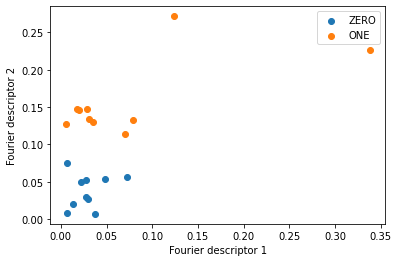

In [7]:
feature_x_zero = []
feature_y_zero = []
feature_x_ones = []
feature_y_ones = []

for im in zeros_im:
    tmp = get_contour(pre_process(im))
    uk = tmp[:,1] + 1j*tmp[:,0]
    uk_fft = np.fft.fft(uk)
    norm = (uk_fft[1])
    feature_x_zero.append(abs(uk_fft[2]/(norm)))
    feature_y_zero.append(abs(uk_fft[3]/(norm)))

for im in ones_im:
    tmp = get_contour(pre_process(im))
    uk = tmp[:,1] + 1j*tmp[:,0]
    uk_fft = np.fft.fft(uk)
    norm = (uk_fft[1])
    feature_x_ones.append(abs(uk_fft[2]/(norm)))
    feature_y_ones.append(abs(uk_fft[3]/(norm)))
                          
plt.scatter(feature_x_zero, feature_y_zero, label='ZERO')
plt.scatter(feature_x_ones, feature_y_ones, label='ONE')
plt.xlabel('Fourier descriptor 1')
plt.ylabel('Fourier descriptor 2')
plt.legend()

**Conclusion** : We see above the features for ZEROS and ONES. We see that the features we obtain do form clusters. However, for ONES, the intra-class variance is quite high. We have two clear outliers. Exploring further, we see that these outliers correspond to images 1_5 and 1_9. This is because the contours for these have a slightly different shape than the other ONE images.

Now, let us explore the effect of translation, rotation and scaling on these features.

#### Effect of rotation

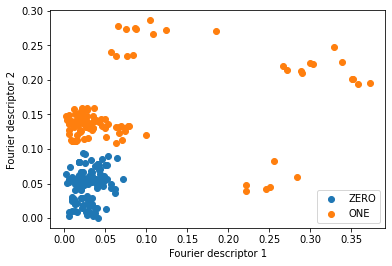

In [8]:
feature_x_zero = []
feature_y_zero = []
feature_x_ones = []
feature_y_ones = []

for im in zeros_im:
    for angle in list(range(0,360,30)):
        tmp = get_contour(transform.rotate(pre_process(im),angle))
        uk = tmp[:,1] + 1j*tmp[:,0]
        uk_fft = np.fft.fft(uk)
        norm = (uk_fft[1])    
        feature_x_zero.append(abs(uk_fft[2]/(norm)))
        feature_y_zero.append(abs(uk_fft[3]/(norm)))
        
for im in ones_im:
    for angle in list(range(0,360,30)):
        tmp = get_contour(transform.rotate(pre_process(im),angle))
        uk = tmp[:,1] + 1j*tmp[:,0]
        uk_fft = np.fft.fft(uk)
        norm = (uk_fft[1])    
        feature_x_ones.append(abs(uk_fft[2]/(norm)))
        feature_y_ones.append(abs(uk_fft[3]/(norm)))

plt.scatter(feature_x_zero, feature_y_zero, label='ZERO')
plt.scatter(feature_x_ones, feature_y_ones, label='ONE')
plt.xlabel('Fourier descriptor 1')
plt.ylabel('Fourier descriptor 2')
plt.legend()

#### Effect of scaling

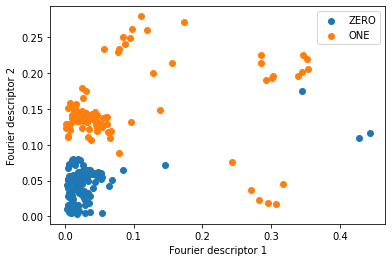

In [9]:
feature_x_zero = []
feature_y_zero = []
feature_x_ones = []
feature_y_ones = []
scale_list = [0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8]

for im in zeros_im:
    for scale in scale_list:
        tmp = get_contour(transform.rescale(pre_process(im),scale))
        uk = tmp[:,1] + 1j*tmp[:,0]
        uk_fft = np.fft.fft(uk)
        norm = (uk_fft[1])    
        feature_x_zero.append(abs(uk_fft[2]/(norm)))
        feature_y_zero.append(abs(uk_fft[3]/(norm)))
        
for im in ones_im:
    for scale in scale_list:
        tmp = get_contour(transform.rescale(pre_process(im),scale))
        uk = tmp[:,1] + 1j*tmp[:,0]
        uk_fft = np.fft.fft(uk)
        norm = (uk_fft[1])    
        feature_x_ones.append(abs(uk_fft[2]/(norm)))
        feature_y_ones.append(abs(uk_fft[3]/(norm)))

plt.scatter(feature_x_zero, feature_y_zero, label='ZERO')
plt.scatter(feature_x_ones, feature_y_ones, label='ONE')
plt.xlabel('Fourier descriptor 1')
plt.ylabel('Fourier descriptor 2')
plt.legend()

**Conclusion** : As we see in each of the above plots, the features we have derived from the Fourier Descriptors are mainly invariant to scaling, rotation, with the exception of a few outliers. Also, the intra-cluster distance for ONES is quite large.

In order to obtain tighter clusters, we can consider other features, some of which we describe in the section below.

### 1.3 Additional method(s)
Add your implementation and discussion

#### 1.3.1 T-SNE

T-SNE state t-distributed statistics neighborhood embedding system. PCA is a very simple old technique but nowadays T-SNE used widely. all cases where PCA have limitation T-SNE can be used. PCA preserve global structure while T-SNE can preserve the local structure. it is an iterative algorithm where at every iteration, it tries to reach a better solution.

Taking every point in high dimensional space and place it into low dimensional space such that it preserves the neighborhood distance between points like X1 and X2 same as in low dimension space X1' and X2'. It does not give any guarantee about the points which is not neighborhood points. t-sne try to keep neighborhood point as close as possible and non-neighborhood point as far away from possible.

In [10]:
data = np.zeros((20,784))
ind = 0
for im in zeros_im:
    data[ind,:] = im.reshape(784)
    ind+=1
    
for im in ones_im:
    data[ind,:] = im.reshape(784)
    ind+=1

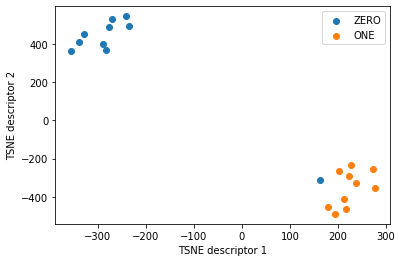

In [11]:
model = TSNE(n_components=2, random_state=0, perplexity=4, n_iter=5000)
tsne_data = model.fit_transform(data)

plt.scatter(tsne_data[0:10,0],tsne_data[0:10,1], label='ZERO')
plt.scatter(tsne_data[10:20,0],tsne_data[10:20,1], label='ONE')
plt.xlabel('TSNE descriptor 1')
plt.ylabel('TSNE descriptor 2')
plt.legend()

**Conclusion** : As we can see above, this method works quite well for our case. We can see two distinct clusters, with high inter-cluster distance and low intra-cluster distance. We have a single outlier, which is because of the fact that the ZERO (0_7) in question has a slightly altered structure.

#### 1.3.2 Moments

Another region-based descriptor that we use in this lab are the $2^{nd}$ order moments known as the moments of inertia. We use the central (aka centered) $2^{nd}$ moments, namely, $\mu_{0,2}$ and $\mu_{2,0}$ to construct the image descriptor. As we saw in the lecture, these image moments are invariant to translation. These moments may be used to determine an important image feature, _orientation_. In general, the orientation of an image describes how the image lies in the field of view or the directions of the principal axes.

In the code below, we use the centered moments $\mu_{2,0}$ and $\mu_{0,2}$ to construct image descriptors to be able to extract a 2D feature vector. To this end, we compute the second order centered moments along X and Y.

In [12]:
def compute_moments(images):
    """
    Calculates the 2nd order centered moments and moment invariants of the image

    Parameters
    ----------
    images : numpy.ndarray
        images 
   
    Returns
    -------
    tuple
        2nd order central moments
    list 
        list of moment invariants 
    """
    # Definition of centered moments (the notation follows that of the lecture slides) for images
    mu_02=[]
    mu_20=[]
    
    # Compute the centerd moment along X and Y for images
    for im in images:
        moments = cv2.moments(im);
        mu_20.append(moments["mu20"])
        mu_02.append(moments["mu02"])
        
    centered_moments_vec = (mu_20,mu_02)
    return centered_moments_vec

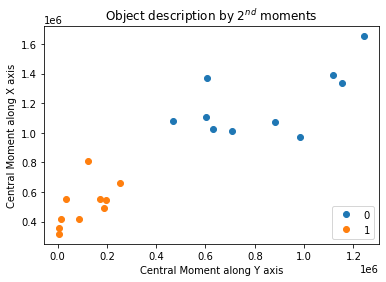

In [13]:
# Compute the 2nd order centerd moments for zeros  
centered_moments_vec_zeros= compute_moments(zeros_im)


# Compute the 2nd order centerd moments for ones 
centered_moments_vec_ones = compute_moments(ones_im)

# Plot the centered moments resutls
zeros_c = plt.plot(centered_moments_vec_zeros[0],centered_moments_vec_zeros[1],"o",label="0")
ones_c  = plt.plot(centered_moments_vec_ones [0],centered_moments_vec_ones [1],"o",label="1")

plt.xlabel('Central Moment along Y axis')
plt.ylabel('Central Moment along X axis')
plt.title('Object description by $2^{nd}$ moments')
plt.legend(loc=4)

plt.show()

__Conclusions__: According to the above plot, we can see that the centered moment along X and Y of zeros and ones images give descriptive features in order to perform clustering. We can see that zeros have higher $2^{nd}$ moments along both X and Y axes and this is fully explained by the shape of Zeros as they are wider than ones and thus have higher second moment along Y axis. Also, in zeros, we have two pixels for every X and thus zeros have higher moment of intertia in X direction. Another observation is that the $2^{nd}$ moment of zeros along both X and Y have more variance than ones and this is due to the fact that, in general, zeros have more pixels away from each of the axes than ones and this makes their $2^{nd}$ moments be more sensitive to small changes. 

#### 1.3.3 Histogram of Oriented Gradients (HoG) and Principle Component Analysis (PCA)

The histogram of oriented gradients (HOG) is a feature descriptor. It counts the occurrences of gradient orientation in various parts of the image. In order to find the occurrences (i.e., histogarm) of gradient orientation, we use a cell that moves within the image. The resulting histogram of all gradient orientation will be the image descriptor.
The methos has the following stesp:

1. Divide the image into small connected regions called cells, and for each cell compute a histogram of gradient directions or edge orientations for the pixels within the cell.

2. Discretize each cell into angular bins according to the gradient orientation.

3. Each cell's pixel contributes weighted gradient to its corresponding angular bin.

4. Groups of adjacent cells are considered as spatial regions called blocks. The grouping of cells into a block is the basis for grouping and normalization of histograms.

5. Normalized group of histograms represents the block histogram. The set of these block histograms represents the descriptor.

6. Use PCA to pick the first 2 most important features (i.e., the first two principle components)

We use a block size of 8x8, cell size of 2x2, and a stride of 4x4. Smaller block and cell sizes help find more features. However, too small cell and block sizes used can result in a too sensitive descriptive model and hence would give erroneous features.

In [14]:
def compute_HoG_descriptor(images, HoG_descriptor):
    """
    Calculates Histogram of Oriented Gradients of the image to find the features of the images.

    Parameters
    ----------
    images : numpy.ndarray
        images 
    HoG_descriptor: cv2.HOGDescriptor
        HoG  ddescriptor object 
   
    Returns
    -------
    list
        list of features

    """
    # List of features
    features = []
    
    # Compute the HoG description of images
    for im in images:
        descriptions = HoG_descriptor.compute(im)
        
        # Normalize 
        normalized = [item for sublist in descriptions for item in sublist]
        features.append(normalized)

    return features

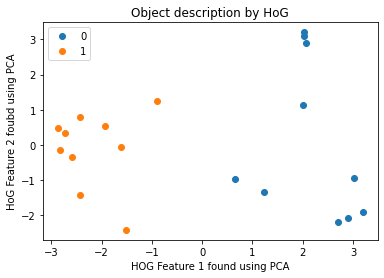

In [15]:
# All features list
all_features = []

# Calculate HoG descriptor with window size of 8x8, cell size of 2x2, and stride of 4x4
HoG_descriptor = cv2.HOGDescriptor((28,28),(8,8),(4,4),(2,2),8)

# Compute the HoG description of zeros  
features_zeros = compute_HoG_descriptor(zeros_im, HoG_descriptor)
all_features.append(features_zeros)

# Compute the HoG description of ones  
features_ones = compute_HoG_descriptor(ones_im, HoG_descriptor)
all_features.append(features_ones)

# Reshape the features vector from 3D to 2D 
all_features = np.reshape(all_features,(np.shape(all_features)[0]*np.shape(all_features)[1],np.shape(all_features)[2]))

# Combine the features using PCA
pca = PCA(n_components=2)
features_2d = pca.fit_transform(all_features)

# Plot the results
zeros = plt.plot(features_2d.transpose()[0][10:20],features_2d.transpose()[1][10:20],"o", label="0")
ones = plt.plot(features_2d.transpose()[0][0:10],features_2d.transpose()[1][0:10], "o", label="1")

plt.xlabel('HOG Feature 1 found using PCA')
plt.ylabel('HoG Feature 2 foubd using PCA')
plt.title('Object description by HoG')
plt.legend(loc=2)

plt.show()

__Conclusion:__ According to the above plot, we can see that, compared to the previous methods, the points in the two clusters are further apart and we have larger various in them. The larger variance among the zero image instances in the above plot is due to the fact that zeros are more sensitive to scaling than ones. 

#### 1.3.4 Simple region-based descriptors

Here we analyse simple descriptors that depend on the object region :_region based descriptors_.

In [16]:
# Preparation for plotting features
def rotation(image):
    '''
    Applying rotation to get more images.
    A rotation affect the phase of all the descriptors by the same amount, and does not modify their amplitude
    '''
    rotate90d = [transform.rotate(i, 90, resize=False, preserve_range=True).astype('uint8') for i in image]
    rotate180d = [transform.rotate(i, 180, resize=False, preserve_range=True).astype('uint8') for i in image]
    rotate270d = [transform.rotate(i, 270, resize=False, preserve_range=True).astype('uint8') for i in image]
    return  list(image) + rotate90d + rotate180d + rotate270d

def featureImages(im, f1, f2):
    imageRotated = rotation(im)
    features = []
    for i in imageRotated:
        a1 = f1(i)
        a2 = f2(i)
        features.append([a1, a2])
    features = np.array(features)
    return features, [f1.__name__, f2.__name__]

def _pltF(imFeatures, features, labels):
    plt.figure(figsize=(8,8))
    for f, l, c in zip(imFeatures, labels, ['r', 'b']):
        plt.scatter(f[:,0], f[:,1], label=l, c=c, s=50)
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.legend()
    plt.grid(True)
    plt.title('{} vs {} descriptors'.format(features[0], features[1]))
    
def plotFeatures(method1, method2):
    listImages = [zeros_im, ones_im]
    listImagesResult = []
    for im in listImages:
        imF, fName = featureImages(im, method1, method2)
        listImagesResult.append(imF)
    _pltF(listImagesResult, fName, range(len(listImages)))

##### 1.3.4.1 Compacity

Compacity is the ratio of perimeter square to the object area. It describes compactness of the object. For example, 
circle has the minimum compacity. Compycity is invariant to the rotation. 

In [17]:
def compacity(image):
    _,thresh1 = cv2.threshold(image,40,255,cv2.THRESH_BINARY)
    P = measure.perimeter(thresh1>0, neighbourhood=1)
    A = np.count_nonzero(thresh1)
    C = (P**2)/A
    return C

##### 1.3.4.2 Elongation

Elongation is the ratio between  the maximum diameter of the object and its minimum diameter perpendicular to it. It is also invariant to the object rotation.

In [18]:
def elongation(image):
    image = ndimage.grey_opening(image,size = (2,2))
    _,thresh1 = cv2.threshold(image,40,255,cv2.THRESH_BINARY)
    moment = cv2.moments(thresh1)
    xcoor = moment['mu20'] + moment['mu02']
    ycoor = 4 * moment['mu11']**2 + (moment['mu20'] - moment['mu02'])**2
    return (xcoor + ycoor**0.5) / (xcoor - ycoor**0.5)

##### 1.3.4.3 Rectangularity
Rectangularity is the ratio between the object area and its largest circumscript rectangle. 

In [19]:
def rectangularity(image):
    _,thresh1 = cv2.threshold(image,40,255,cv2.THRESH_BINARY)
    _, contour, _ = cv2.findContours(image,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    # area = cv2.contourArea(contour[0])
    area = np.count_nonzero(thresh1)
    xcoor, ycoor, width, height = cv2.boundingRect(contour[0])
    rect_area = width*height
    rectangularitY = float(area)/rect_area
    return rectangularitY

##### 1.3.4.4 Perimeter

Perimeter of the detected contour for each object is another desciptor that we would like to examine.
We first binarize each image with a threshold, and then calculate the perimeter with 1 neighbour connectivity on binary image.

In [20]:
def perimeter(image):
    _,thresh1 = cv2.threshold(image,40,255,cv2.THRESH_BINARY)
    perimeter = measure.perimeter(thresh1>0, neighbourhood=1)
    return perimeter

##### 1.3.4.5 results and discussion
* __compacity__ vs __elongation__:<br />
According to the plot bellow compacity of 0 is larger than compacity of 1 values.  
Furthermore, elongation of number 1 images has larger variance than elongation of number 0. 
Compacity is also larger than circle compacity (4$\pi$) which is validated by our results.
Two image sets are separable in the 2D plot. Therefore, both compacity and elongation are appropriate descriptors for our images.

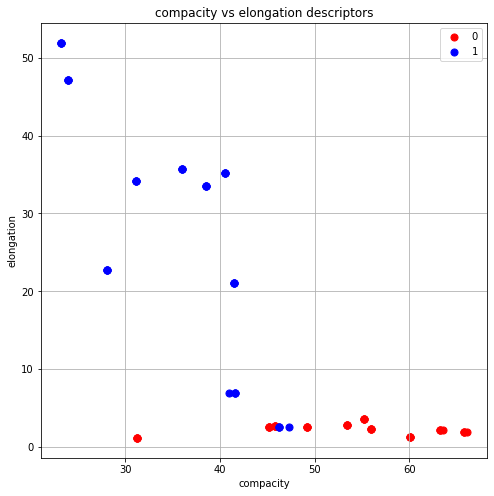

In [21]:
plotFeatures(compacity, elongation)

* __compacity__ vs __rectangularity__:<br />
According to the result, rectangularity of two image sets is not separate enough. We can conclude that rectangularity is not 
an appropriate descriptor for our data.

In [22]:
plotFeatures(compacity, rectangularity)

ValueError: not enough values to unpack (expected 3, got 2)

* __compacity__ vs __perimeter__:<br />
The result bellow confirms that perimeter is an appropriate descriptor for our data. Indeed, perimeter values for iamges 
number 1 and 0 are separate with each other. We can conclude that using both compacity and perimeter can provide us the 
best simple region based descriptors for our dataset.

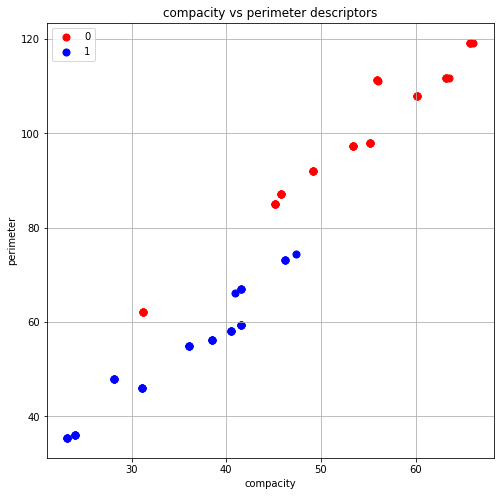

In [23]:
plotFeatures(compacity, perimeter)

#### 1.3.5 Skeleton

Here we define two skeletonization algorithms and then define and examine
descriptors to separate numbers.

##### 1.3.5.1 Medial-xis Skeletonization

We first binarize the image and inside the foreground which is supposed to contain pixels of the number we find the set of all points that each has more than
one closes point on the forwground boundary. This will render one-pixel wide skeleton of the object with the same connectivity as the original object. 
The result also is refered as _topological skeleton_:   

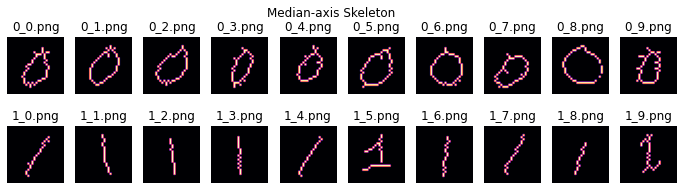

In [24]:
skeleton_zero=[]
median_skeleton_zero=[]
median_skeleton_zero_r = []
Binary=[]
for im, nm in zip(zeros_im, zeros_names):
    # Transforming image to binary image
    ret,thresh = cv2.threshold(im,230,255,cv2.THRESH_BINARY)
    np_img = np.array(thresh)
    np_img[np_img > 0] = 1
    # Skeletonizing the image
    skeleton_zero.append(skeletonize(np_img))
    skel, r = medial_axis(np_img, return_distance=True)
    median_skeleton_zero_r.append(np.sum(r[r>1]))
    
    median_skeleton_zero.append(medial_axis(np_img))

skeleton_one=[]
median_skeleton_one = []
median_skeleton_one_r = []
Binary=[]
for im, nm in zip(ones_im, ones_names):
    # Transforming image to binary image
    ret,thresh = cv2.threshold(im,230,255,cv2.THRESH_BINARY)
    np_img = np.array(thresh)
    np_img[np_img > 0] = 1
    # Skeletonizing the image
    skeleton_one.append(skeletonize(np_img))
    skel, r = medial_axis(np_img, return_distance=True)
    median_skeleton_one_r.append(np.sum(r[r>1]))
    
    median_skeleton_one.append(medial_axis(np_img))


# Plotting the skeletons
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3)) 
plt.suptitle('Median-axis Skeleton')
for ax, im, nm in zip(axes[0], median_skeleton_zero, zeros_names):
    ax.imshow(im, cmap='magma')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], median_skeleton_one, ones_names):
    ax.imshow(im, cmap='magma')
    ax.axis('off')
    ax.set_title(nm)

Obviously, one descriptor that inspires extracting out ot the median skeleton is total number of the points in the skeleton.
The other descriptor that we utilize is the distance sum of the points in the object which are farther than 1 pixel from the background. This can be achieved by a threshold on the ditanse transform _r_ corresponding the skeleton.

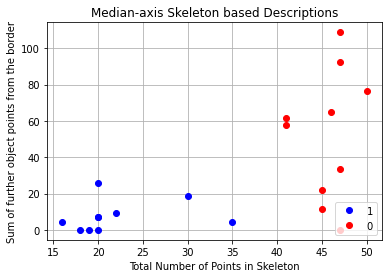

In [25]:
# Removing the first and last rows and columns from images
_,h,w= np.shape(median_skeleton_zero)
h=h-1
w=w-1
skeleton_zero_check=median_skeleton_zero[:][1:h][1:w]

# Initilizing the variables
Total_number_of_points0=[]
Total_number_of_corners0=[]

# Main for loop for feature extraction of zeros
for im in np.arange(0,np.shape(median_skeleton_zero)[0],1):
    Number_of_points=0
    Number_of_corners=0
    vertical_line=[]
    for x in np.arange(1,h,1):
        for y in np.arange(1,w,1):
            if median_skeleton_zero[im][x][y]==True:
                 # Extracting the number of points
                Number_of_points=Number_of_points+1
                s=0
                for a in np.arange(-1,1,1):
                    for b in np.arange(-1,1,1):
                        if median_skeleton_zero[im][x+a][y+b]== True:
                            s=s+1
                if s==2:
                    # Extracting the number of corners
                    Number_of_corners=Number_of_corners+1

    Total_number_of_points0.append(Number_of_points)
    Total_number_of_corners0.append(Number_of_corners)
    
# Removing the first and last rows and columns from images    
_,h,w= np.shape(median_skeleton_one)
h=h-1
w=w-1
skeleton_one_check=median_skeleton_one[:][1:h][1:w]

# Initilizing the variables
Total_number_of_points1=[]
Total_number_of_corners1=[]

# Main for loop for feature extraction of ones
for im in np.arange(0,np.shape(median_skeleton_one)[0],1):
    Number_of_points=0
    Number_of_corners=0
    for x in np.arange(1,h,1):
        for y in np.arange(1,w,1):
            if median_skeleton_one[im][x][y]==True:
                # Extracting the number of points
                Number_of_points=Number_of_points+1
                s=0
                for a in np.arange(-1,1,1):
                    for b in np.arange(-1,1,1):
                        if median_skeleton_one[im][x+a][y+b]== True:
                            s=s+1
                if s==2:
                    # Extracting the number of corners
                    Number_of_corners=Number_of_corners+1
    Total_number_of_points1.append(Number_of_points)
    Total_number_of_corners1.append(Number_of_corners) 

# Plotting the features plot
Plot_ones = plt.plot(Total_number_of_points1,median_skeleton_one_r, "o", label="1", c='b')
Plot_zeros = plt.plot(Total_number_of_points0,median_skeleton_zero_r, "o", label="0", c='r')
plt.legend(loc=4)
plt.xlabel('Total Number of Points in Skeleton')
plt.ylabel('Sum of further object points from the border')
plt.title('Median-axis Skeleton based Descriptions')
plt.grid(True)
plt.show()

The result indicates that indeed selected descriptors can separate zero and one numbers. It shows that the total number of 
points in the median-axis skeleton is quite separating two classes regardless of existing outliers. Furthermore, the further
 object points sum from the borders of each object is overally higher for the zero objects which was expected inasmuch as 
 the object one is thinner than zero.

##### 1.3.5.2 Thinning Skeletonization

Here we utilize _fast parallel algorithm for thinning digital patterns_
invented by Zha et al. This algorithm works by making successive passes of the image, removing pixels on object borders. This continues until no more pixels can be removed.
The image is correlated with a mask that assigns each pixel a number in one range of numbers corresponding to each possible pattern of its 8 neighbouring pixels. Afterwards, a look up table is used to assign the pixels a pattern id, which are selectively removed during the iterations.

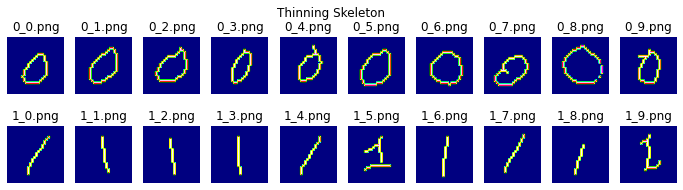

In [26]:
skeleton_zero=[]
median_skeleton_zero=[]
median_skeleton_zero_r = []
Binary=[]
for im, nm in zip(zeros_im, zeros_names):
    # Transforming image to binary image
    ret,thresh = cv2.threshold(im,230,255,cv2.THRESH_BINARY)
    np_img = np.array(thresh)
    np_img[np_img > 0] = 1
    # Skeletonizing the image
    skeleton_zero.append(skeletonize(np_img))

skeleton_one=[]
Binary=[]
for im, nm in zip(ones_im, ones_names):
    # Transforming image to binary image
    ret,thresh = cv2.threshold(im,230,255,cv2.THRESH_BINARY)
    np_img = np.array(thresh)
    np_img[np_img > 0] = 1
    # Skeletonizing the image
    skeleton_one.append(skeletonize(np_img))

# Plotting the skeletons
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3)) 
plt.suptitle('Thinning Skeleton')
for ax, im, nm in zip(axes[0], skeleton_zero, zeros_names):
    ax.imshow(im, cmap='gist_ncar')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], skeleton_one, ones_names):
    ax.imshow(im, cmap='gist_ncar')
    ax.axis('off')
    ax.set_title(nm)

Now we have to extract two features from the skeletonized images to perform the description.
 The first feature is the number of corner pixels in each image. The corners are the yellow pixels
  that just have one yellow neighbor pixel. In order to count the corner pixels, we find the points
   which belong to skeleton and check all their neighbors. If there is just one neighbor pixel which
    also belongs to skeleton, we have to count that point as a corner.

The second feature that we used is the total number of skeleton pixels and we expect to have a higher
 number for the zeros.


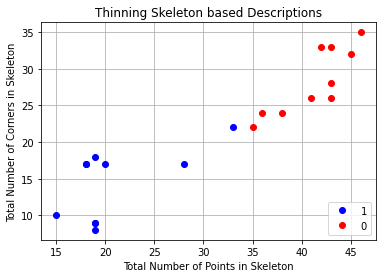

In [27]:
# Removing the first and last rows and columns from images
_,h,w= np.shape(skeleton_zero)
h=h-1
w=w-1
skeleton_zero_check=skeleton_zero[:][1:h][1:w]

# Initilizing the variables
Total_number_of_points0=[]
Total_number_of_corners0=[]

# Main for loop for feature extraction of zeros
for im in np.arange(0,np.shape(skeleton_zero)[0],1):
    Number_of_points=0
    Number_of_corners=0
    vertical_line=[]
    for x in np.arange(1,h,1):
        for y in np.arange(1,w,1):
            if skeleton_zero[im][x][y]==True:
                 # Extracting the number of points
                Number_of_points=Number_of_points+1
                s=0
                for a in np.arange(-1,1,1):
                    for b in np.arange(-1,1,1):
                        if skeleton_zero[im][x+a][y+b]== True:
                            s=s+1
                if s==2:
                    # Extracting the number of corners
                    Number_of_corners=Number_of_corners+1

    Total_number_of_points0.append(Number_of_points)
    Total_number_of_corners0.append(Number_of_corners)
    
# Removing the first and last rows and columns from images    
_,h,w= np.shape(skeleton_one)
h=h-1
w=w-1
skeleton_one_check=skeleton_one[:][1:h][1:w]

# Initilizing the variables
Total_number_of_points1=[]
Total_number_of_corners1=[]

# Main for loop for feature extraction of ones
for im in np.arange(0,np.shape(skeleton_one)[0],1):
    Number_of_points=0
    Number_of_corners=0
    for x in np.arange(1,h,1):
        for y in np.arange(1,w,1):
            if skeleton_one[im][x][y]==True:
                # Extracting the number of points
                Number_of_points=Number_of_points+1
                s=0
                for a in np.arange(-1,1,1):
                    for b in np.arange(-1,1,1):
                        if skeleton_one[im][x+a][y+b]== True:
                            s=s+1
                if s==2:
                    # Extracting the number of corners
                    Number_of_corners=Number_of_corners+1
    Total_number_of_points1.append(Number_of_points)
    Total_number_of_corners1.append(Number_of_corners) 

# Plotting the features plot
Plot_ones = plt.plot(Total_number_of_points1,Total_number_of_corners1, "o", label="1", c='b')
Plot_zeros = plt.plot(Total_number_of_points0,Total_number_of_corners0, "o", label="0", c='r')
plt.legend(loc=4)
plt.xlabel('Total Number of Points in Skeleton')
plt.ylabel('Total Number of Corners in Skeleton')
plt.title('Thinning Skeleton based Descriptions')
plt.grid(True)
plt.show()

 According to the result above, our skeleton method performs a good description and separation for zero and one numbers.
  In fact, _fast parallel algorithm for thinning digital patterns_ provides smoother skeleton; thereafter, the number of corners
   is also a powerful feature to separate objects utilizing thinning skeleton. Nevertheless, there are outliers due to the 
   different handwriting style.

## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

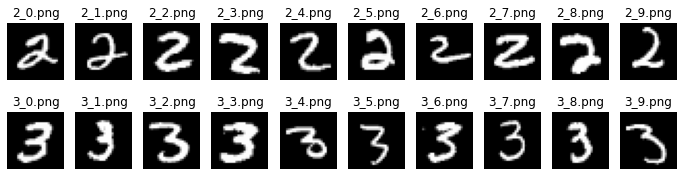

In [28]:
#  Load zeros
twos_path = os.path.join(data_base_path, data_folder, 'part2', '2')
twos_names = [nm for nm in os.listdir(twos_path) if '.png' in nm]  # make sure to only load .png
twos_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(twos_path, nm) for nm in twos_names])
twos_im = skimage.io.concatenate_images(ic)
#  Load ones
threes_path = os.path.join(data_base_path, data_folder, 'part2', '3')
threes_names = [nm for nm in os.listdir(threes_path) if '.png' in nm]  # make sure to only load .png
threes_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(threes_path, nm) for nm in threes_names]))
threes_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 2.2 Additional method(s) and conclusion
Add your implementations and discussions here

#### 2.2.1 Fourier Descriptors

We now apply the same fourier descriptors as we did for zeros and ones.

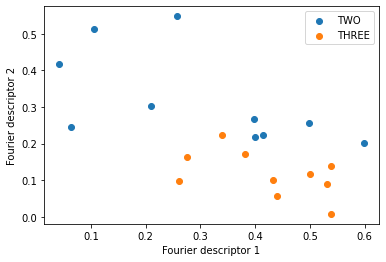

In [29]:
feature_x_two = []
feature_y_two = []
feature_x_three = []
feature_y_three = []

for im in twos_im:
    tmp = get_contour(pre_process(im))
    uk = tmp[:,1] + 1j*tmp[:,0]
    uk_fft = np.fft.fft(uk)
    norm = (uk_fft[1])
    feature_x_two.append(abs(uk_fft[2]/(norm)))
    feature_y_two.append(abs(uk_fft[3]/(norm)))

for im in threes_im:
    tmp = get_contour(pre_process(im))
    uk = tmp[:,1] + 1j*tmp[:,0]
    uk_fft = np.fft.fft(uk)
    norm = (uk_fft[1])
    feature_x_three.append(abs(uk_fft[2]/(norm)))
    feature_y_three.append(abs(uk_fft[3]/(norm)))
                          
plt.scatter(feature_x_two, feature_y_two, label='TWO')
plt.scatter(feature_x_three, feature_y_three, label='THREE')
plt.xlabel('Fourier descriptor 1')
plt.ylabel('Fourier descriptor 2')
plt.legend()

**Conclusion** : We observe that Fourier Descriptors are not good enough to separate TWOS and THREES images. This moght be the case because the fourier frequencies of these two numbers are quite similar and not quite good enough to differentiate between the two.

We also now plot the Fourier Descriptors of all four numbers on the same plot and observe.

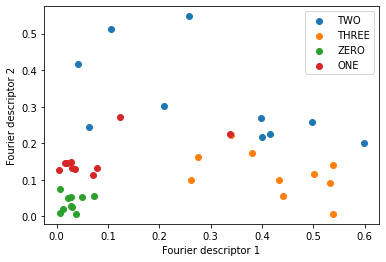

In [30]:
feature_x_zero = []
feature_y_zero = []
feature_x_ones = []
feature_y_ones = []

for im in zeros_im:
    tmp = get_contour(pre_process(im))
    uk = tmp[:,1] + 1j*tmp[:,0]
    uk_fft = np.fft.fft(uk)
    norm = (uk_fft[1])
    feature_x_zero.append(abs(uk_fft[2]/(norm)))
    feature_y_zero.append(abs(uk_fft[3]/(norm)))

for im in ones_im:
    tmp = get_contour(pre_process(im))
    uk = tmp[:,1] + 1j*tmp[:,0]
    uk_fft = np.fft.fft(uk)
    norm = (uk_fft[1])
    feature_x_ones.append(abs(uk_fft[2]/(norm)))
    feature_y_ones.append(abs(uk_fft[3]/(norm)))
    
feature_x_two = []
feature_y_two = []
feature_x_three = []
feature_y_three = []

for im in twos_im:
    tmp = get_contour(pre_process(im))
    uk = tmp[:,1] + 1j*tmp[:,0]
    uk_fft = np.fft.fft(uk)
    norm = (uk_fft[1])
    feature_x_two.append(abs(uk_fft[2]/(norm)))
    feature_y_two.append(abs(uk_fft[3]/(norm)))

for im in threes_im:
    tmp = get_contour(pre_process(im))
    uk = tmp[:,1] + 1j*tmp[:,0]
    uk_fft = np.fft.fft(uk)
    norm = (uk_fft[1])
    feature_x_three.append(abs(uk_fft[2]/(norm)))
    feature_y_three.append(abs(uk_fft[3]/(norm)))
                          
plt.scatter(feature_x_two, feature_y_two, label='TWO')
plt.scatter(feature_x_three, feature_y_three, label='THREE')                          
plt.scatter(feature_x_zero, feature_y_zero, label='ZERO')
plt.scatter(feature_x_ones, feature_y_ones, label='ONE')
plt.xlabel('Fourier descriptor 1')
plt.ylabel('Fourier descriptor 2')
plt.legend()

**Conclusion** : Clearly, we see that Fourier Descriptors are not enough to separate all four numbers. Hence, we would need to rely on one of additional methods discussed below.

#### 2.2.2 T-SNE

In [31]:
data1 = np.zeros((40,784))
ind = 0
for im in zeros_im:
    data1[ind,:] = im.reshape(784)
    ind+=1
    
for im in ones_im:
    data1[ind,:] = im.reshape(784)
    ind+=1

for im in twos_im:
    data1[ind,:] = im.reshape(784)
    ind+=1
    
for im in threes_im:
    data1[ind,:] = im.reshape(784)
    ind+=1

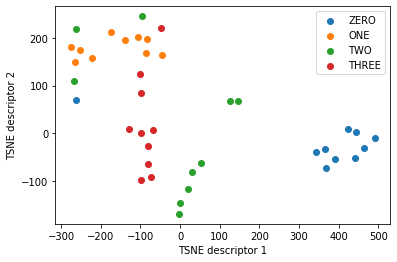

In [32]:
model = TSNE(n_components=2, random_state=0, perplexity=4, n_iter=5000)
tsne_data = model.fit_transform(data1)

plt.scatter(tsne_data[0:10,0],tsne_data[0:10,1], label='ZERO')
plt.scatter(tsne_data[10:20,0],tsne_data[10:20,1], label='ONE')
plt.scatter(tsne_data[20:30,0],tsne_data[20:30,1], label='TWO')
plt.scatter(tsne_data[30:40,0],tsne_data[30:40,1], label='THREE')
plt.xlabel('TSNE descriptor 1')
plt.ylabel('TSNE descriptor 2')

plt.legend()

**Conclusion** :We observe that the clusters are not good enough to be able to separate the four digits from each other. The problem is when we revel the image, we are losing neighborhood information.

#### 2.2.3 Moments

Here we use the moments method described in section 1.3.3 to construct image descriptors for images of 2's and 3's. 

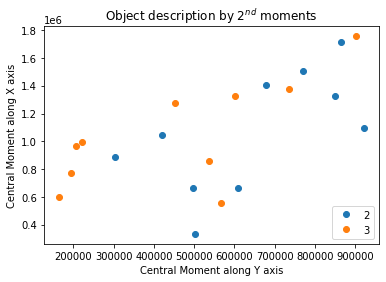

In [33]:
# Compute the 2nd order centerd moments for twos  
centered_moments_vec_twos = compute_moments(twos_im)

# Compute the 2nd order centerd moments for threes 
centered_moments_vec_threes = compute_moments(threes_im)

# Plot the centered moments resutls
twos_c = plt.plot(centered_moments_vec_twos[0],centered_moments_vec_twos[1],"o",label="2")
threes_c  = plt.plot(centered_moments_vec_threes [0],centered_moments_vec_threes [1],"o",label="3")

plt.xlabel('Central Moment along Y axis')
plt.ylabel('Central Moment along X axis')
plt.title('Object description by $2^{nd}$ moments')
plt.legend(loc=4)

plt.show()

__Conclusion__: We see that the this method is not as capable of clustering the images of 2's and 3's as it was for the case of 1's and 0's. The reason is that, in contrast to digits 0 and 1, digits 2 and 3 do not have distictive features along the X and Y axes as long as the $2^{nd}$ moments are concerned and thus the $2ˆ{nd}$ moments cannot be used to define features for images of twos and threes.  

To see if we the moments method is capable of discriminating all 4 digits, we plot all results in a signle plot: 

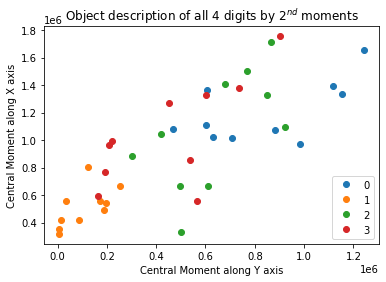

In [34]:
# Plot the centered moments resutls
zeros_c = plt.plot(centered_moments_vec_zeros[0],centered_moments_vec_zeros[1],"o",label="0")
ones_c  = plt.plot(centered_moments_vec_ones [0],centered_moments_vec_ones [1],"o",label="1")
twos_c = plt.plot(centered_moments_vec_twos[0],centered_moments_vec_twos[1],"o",label="2")
threes_c  = plt.plot(centered_moments_vec_threes [0],centered_moments_vec_threes [1],"o",label="3")

plt.xlabel('Central Moment along Y axis')
plt.ylabel('Central Moment along X axis')
plt.title('Object description of all 4 digits by $2^{nd}$ moments')
plt.legend(loc=4)

plt.show()

__Conclusions:__ The $2^{nd}$ centered moments cannot discriminate all 4 digits with a 2D feature vector as we cannot see distictive clusters of digit instances in the above plot. 

#### 2.2.4 Histogram of Oriented Gradients (HoG) and PCA

Now, we use HoG described in section 1.3.4 in order to construct image descriptor for images of 2's and 3's. 


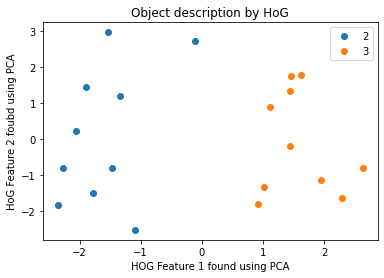

In [35]:
# All features list
all_features_2 = []

# Calculate HoG descriptor with window size of 8x8, cell size of 2x2, and stride of 4x4
HoG_descriptor_2 = cv2.HOGDescriptor((28,28),(8,8),(4,4),(2,2),8)

# Compute the HoG description of twos  
features_twos = compute_HoG_descriptor(twos_im, HoG_descriptor_2)
all_features_2.append(features_twos)

# Compute the HoG description of threes  
features_threes = compute_HoG_descriptor(threes_im, HoG_descriptor_2)
all_features_2.append(features_threes)

# Reshape the features vector from 3D to 2D 
all_features_2 = np.reshape(all_features_2,(np.shape(all_features_2)[0]*np.shape(all_features_2)[1],np.shape(all_features_2)[2]))

# Combine the features using PCA
pca_2 = PCA(n_components=2)
features_2d_2 = pca_2.fit_transform(all_features_2)

# Plot the results
twos = plt.plot(features_2d_2.transpose()[0][10:20],features_2d_2.transpose()[1][10:20],"o", label="2")
threes = plt.plot(features_2d_2.transpose()[0][0:10],features_2d_2.transpose()[1][0:10], "o", label="3")

plt.xlabel('HOG Feature 1 found using PCA')
plt.ylabel('HoG Feature 2 foubd using PCA')
plt.title('Object description by HoG')
plt.legend(loc=1)

plt.show()

__Conclusions:__ According to the above plot, we can see that HoG is capable of extracting features of images of handwritten 2 and 3 digits and can effectively discriminate them and hence we can see two distinguishing clusters among the images of twos and threes. 


Now, we plot all the resutls for all images of 0, 1, 2, and 3 in a single plot to see how the method is capable of discriminating all 4 digits:

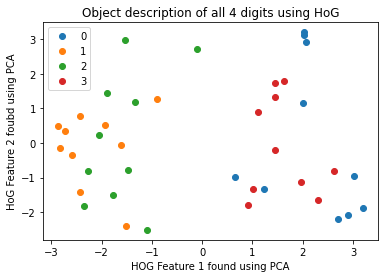

In [36]:
# Plot all HoG results in a single plot
zeros = plt.plot(features_2d.transpose()[0][10:20],features_2d.transpose()[1][10:20],"o", label="0")
ones = plt.plot(features_2d.transpose()[0][0:10],features_2d.transpose()[1][0:10], "o", label="1")
twos = plt.plot(features_2d_2.transpose()[0][10:20],features_2d_2.transpose()[1][10:20],"o", label="2")
threes = plt.plot(features_2d_2.transpose()[0][0:10],features_2d_2.transpose()[1][0:10], "o", label="3")

plt.xlabel('HOG Feature 1 found using PCA')
plt.ylabel('HoG Feature 2 foubd using PCA')
plt.title('Object description of all 4 digits using HoG')
plt.legend(loc=2)

plt.show()

__Conclusions:__ Although HoG could discriminate zeros and ones as well as twos and threes, it is not capable of discriminating all four digits using only a 2D feature vector. We observe that there are two (almost) distictive clusters: one containing images of digits 1 and 2 and the other one containing the images of 0's and 3's. This is expected because as far as the first HoG feature is concerned, digits 1 and 2 look similar and digits 0 and 3 also look alike as 0's and 3's are generally more sensitive to scaling than digits 1 and 2. However, clearly, using a 2D feature vector, this method cannot discriminate all 4 digits. 

#### 2.2.5 Simple region-based descriptors

The represntation of selected descriptors explained in part 1 are as follows:

In [37]:
# Preparation for plotting features
def rotation(image):
    '''
    Applying rotation to get more images.
    A rotation affect the phase of all the descriptors by the same amount, and does not modify their amplitude
    '''
    rotate90d = [transform.rotate(i, 90, resize=False, preserve_range=True).astype('uint8') for i in image]
    rotate180d = [transform.rotate(i, 180, resize=False, preserve_range=True).astype('uint8') for i in image]
    rotate270d = [transform.rotate(i, 270, resize=False, preserve_range=True).astype('uint8') for i in image]
    return  list(image) + rotate90d + rotate180d + rotate270d

def featureImages(im, f1, f2):
    imageRotated = rotation(im)
    features = []
    for i in imageRotated:
        a1 = f1(i)
        a2 = f2(i)
        features.append([a1, a2])
    features = np.array(features)
    return features, [f1.__name__, f2.__name__]

def _pltF(imFeatures, features, labels):
    plt.figure(figsize=(8, 8))
    for f, l, c in zip(imFeatures, labels, ['r', 'b', 'g', 'k']):
        plt.scatter(f[:,0], f[:,1], label=l, c=c, s=50)
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.legend()
    plt.grid(True)
    plt.title('{} vs {} descriptors'.format(features[0], features[1]))
    
def plotFeatures(method1, method2):
    listImages = [zeros_im, ones_im, twos_im, threes_im]
    listImagesResult = []
    for im in listImages:
        imF, fName = featureImages(im, method1, method2)
        listImagesResult.append(imF)
    _pltF(listImagesResult, fName, range(len(listImages)))

In [38]:
def compacity(image):
    _,thresh1 = cv2.threshold(image,40,255,cv2.THRESH_BINARY)
    P = measure.perimeter(thresh1>0, neighbourhood=1)
    A = np.count_nonzero(thresh1)
    C = (P**2)/A
    return C

In [39]:
def elongation(image):
    image = ndimage.grey_opening(image,size = (2,2))
    _,thresh1 = cv2.threshold(image,40,255,cv2.THRESH_BINARY)
    moment = cv2.moments(thresh1)
    xcoor = moment['mu20'] + moment['mu02']
    ycoor = 4 * moment['mu11']**2 + (moment['mu20'] - moment['mu02'])**2
    return (xcoor + ycoor**0.5) / (xcoor - ycoor**0.5)


In [40]:
def rectangularity(image):
    _,thresh1 = cv2.threshold(image,40,255,cv2.THRESH_BINARY)
    _, contour, _ = cv2.findContours(image,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    # area = cv2.contourArea(contour[0])
    area = np.count_nonzero(thresh1)
    xcoor, ycoor, width, height = cv2.boundingRect(contour[0])
    rect_area = width*height
    rectangularitY = float(area)/rect_area
    return rectangularitY


In [41]:
def perimeter(image):
    _,thresh1 = cv2.threshold(image,40,255,cv2.THRESH_BINARY)
    perimeter = measure.perimeter(thresh1>0, neighbourhood=1)
    return perimeter

* __compacity__ vs __elongation__:<br />

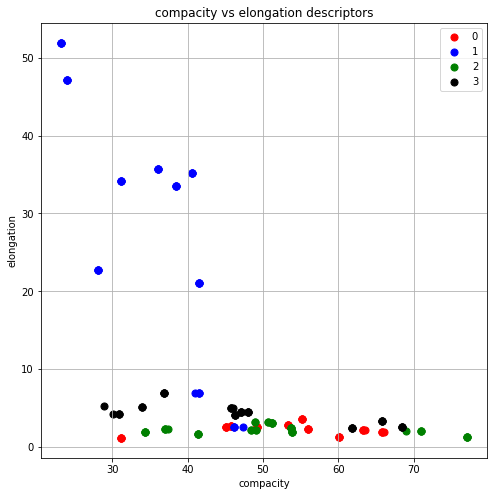

In [42]:
plotFeatures(compacity, elongation)

* __compacity__ vs __rectangularity__:<br />

In [43]:
plotFeatures(compacity, rectangularity)

ValueError: not enough values to unpack (expected 3, got 2)

* __compacity__ vs __perimeter__:<br />

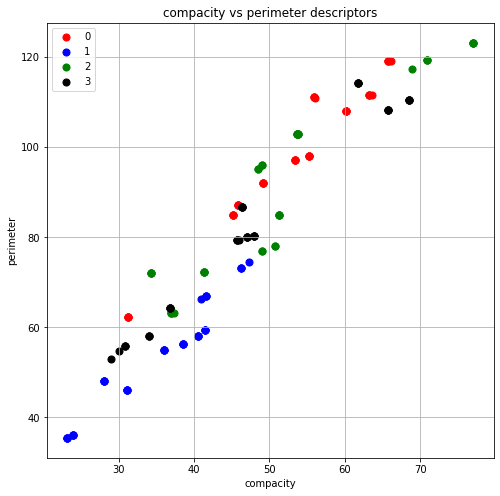

In [44]:
plotFeatures(compacity, perimeter)

##### 2.2.5.1 Discussion

According to the results obtained for four numbers, it is concluded that none of the selected pair of 
simple region based features could separate all four numbers. 

#### 2.2.6 Skeleton

Following the explained Skeleton based methods in part 1 we have:

##### 2.2.6.1 Medial-xis Skeletonization

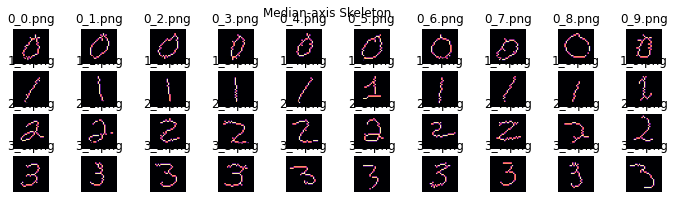

In [45]:
skeleton_zero=[]
median_skeleton_zero=[]
median_skeleton_zero_r = []
Binary=[]
for im, nm in zip(zeros_im, zeros_names):
    # Transforming image to binary image
    ret,thresh = cv2.threshold(im,230,255,cv2.THRESH_BINARY)
    np_img = np.array(thresh)
    np_img[np_img > 0] = 1
    # Skeletonizing the image
    skeleton_zero.append(skeletonize(np_img))
    skel, r = medial_axis(np_img, return_distance=True)
    median_skeleton_zero_r.append(np.sum(r[r>1]))
    median_skeleton_zero.append(medial_axis(np_img))

skeleton_one=[]
median_skeleton_one = []
median_skeleton_one_r = []
Binary=[]
for im, nm in zip(ones_im, ones_names):
    # Transforming image to binary image
    ret,thresh = cv2.threshold(im,230,255,cv2.THRESH_BINARY)
    np_img = np.array(thresh)
    np_img[np_img > 0] = 1
    # Skeletonizing the image
    skeleton_one.append(skeletonize(np_img))
    skel, r = medial_axis(np_img, return_distance=True)
    median_skeleton_one_r.append(np.sum(r[r>1]))
    median_skeleton_one.append(medial_axis(np_img))

skeleton_two=[]
median_skeleton_two = []
median_skeleton_two_r = []
Binary=[]
for im, nm in zip(twos_im, twos_names):
    # Transforming image to binary image
    ret,thresh = cv2.threshold(im,230,255,cv2.THRESH_BINARY)
    np_img = np.array(thresh)
    np_img[np_img > 0] = 1
    # Skeletonizing the image
    skeleton_one.append(skeletonize(np_img))
    skel, r = medial_axis(np_img, return_distance=True)
    median_skeleton_two_r.append(np.sum(r[r>1]))
    median_skeleton_two.append(medial_axis(np_img))

skeleton_three=[]
median_skeleton_three = []
median_skeleton_three_r = []
Binary=[]
for im, nm in zip(threes_im, threes_names):
    # Transforming image to binary image
    ret,thresh = cv2.threshold(im,230,255,cv2.THRESH_BINARY)
    np_img = np.array(thresh)
    np_img[np_img > 0] = 1
    # Skeletonizing the image
    skeleton_three.append(skeletonize(np_img))
    skel, r = medial_axis(np_img, return_distance=True)
    median_skeleton_three_r.append(np.sum(r[r>1]))
    median_skeleton_three.append(medial_axis(np_img))


# Plotting the skeletons
fig, axes = plt.subplots(4, len(zeros_im), figsize=(12, 3)) 
plt.suptitle('Median-axis Skeleton')
for ax, im, nm in zip(axes[0], median_skeleton_zero, zeros_names):
    ax.imshow(im, cmap='magma')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], median_skeleton_one, ones_names):
    ax.imshow(im, cmap='magma')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[2], median_skeleton_two, twos_names):
    ax.imshow(im, cmap='magma')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[3], median_skeleton_three, threes_names):
    ax.imshow(im, cmap='magma')
    ax.axis('off')
    ax.set_title(nm)


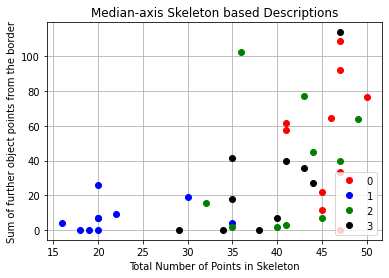

In [46]:
# Removing the first and last rows and columns from images
_,h,w= np.shape(median_skeleton_zero)
h=h-1
w=w-1
skeleton_zero_check=median_skeleton_zero[:][1:h][1:w]

# Initilizing the variables
Total_number_of_points0=[]
Total_number_of_corners0=[]

# Main for loop for feature extraction of zeros
for im in np.arange(0,np.shape(median_skeleton_zero)[0],1):
    Number_of_points=0
    Number_of_corners=0
    vertical_line=[]
    for x in np.arange(1,h,1):
        for y in np.arange(1,w,1):
            if median_skeleton_zero[im][x][y]==True:
                 # Extracting the number of points
                Number_of_points=Number_of_points+1
                s=0
                for a in np.arange(-1,1,1):
                    for b in np.arange(-1,1,1):
                        if median_skeleton_zero[im][x+a][y+b]== True:
                            s=s+1
                if s==2:
                    # Extracting the number of corners
                    Number_of_corners=Number_of_corners+1

    Total_number_of_points0.append(Number_of_points)
    Total_number_of_corners0.append(Number_of_corners)
############################################################
# Removing the first and last rows and columns from images    
_,h,w= np.shape(median_skeleton_one)
h=h-1
w=w-1
skeleton_one_check=median_skeleton_one[:][1:h][1:w]

# Initilizing the variables
Total_number_of_points1=[]
Total_number_of_corners1=[]

# Main for loop for feature extraction of ones
for im in np.arange(0,np.shape(median_skeleton_one)[0],1):
    Number_of_points=0
    Number_of_corners=0
    for x in np.arange(1,h,1):
        for y in np.arange(1,w,1):
            if median_skeleton_one[im][x][y]==True:
                # Extracting the number of points
                Number_of_points=Number_of_points+1
                s=0
                for a in np.arange(-1,1,1):
                    for b in np.arange(-1,1,1):
                        if median_skeleton_one[im][x+a][y+b]== True:
                            s=s+1
                if s==2:
                    # Extracting the number of corners
                    Number_of_corners=Number_of_corners+1
    Total_number_of_points1.append(Number_of_points)
    Total_number_of_corners1.append(Number_of_corners) 
############################################################
# Removing the first and last rows and columns from images
_,h,w= np.shape(median_skeleton_two)
h=h-1
w=w-1
skeleton_two_check=median_skeleton_two[:][1:h][1:w]

# Initilizing the variables
Total_number_of_points2=[]
Total_number_of_corners2=[]

# Main for loop for feature extraction of twos
for im in np.arange(0,np.shape(median_skeleton_two)[0],1):
    Number_of_points=0
    Number_of_corners=0
    vertical_line=[]
    for x in np.arange(1,h,1):
        for y in np.arange(1,w,1):
            if median_skeleton_two[im][x][y]==True:
                 # Extracting the number of points
                Number_of_points=Number_of_points+1
                s=0
                for a in np.arange(-1,1,1):
                    for b in np.arange(-1,1,1):
                        if median_skeleton_two[im][x+a][y+b]== True:
                            s=s+1
                if s==2:
                    # Extracting the number of corners
                    Number_of_corners=Number_of_corners+1

    Total_number_of_points2.append(Number_of_points)
    Total_number_of_corners2.append(Number_of_corners)

############################################################
# Removing the first and last rows and columns from images
_,h,w= np.shape(median_skeleton_three)
h=h-1
w=w-1
skeleton_three_check=median_skeleton_three[:][1:h][1:w]

# Initilizing the variables
Total_number_of_points3=[]
Total_number_of_corners3=[]

# Main for loop for feature extraction of threes
for im in np.arange(0,np.shape(median_skeleton_three)[0],1):
    Number_of_points=0
    Number_of_corners=0
    vertical_line=[]
    for x in np.arange(1,h,1):
        for y in np.arange(1,w,1):
            if median_skeleton_three[im][x][y]==True:
                 # Extracting the number of points
                Number_of_points=Number_of_points+1
                s=0
                for a in np.arange(-1,1,1):
                    for b in np.arange(-1,1,1):
                        if median_skeleton_three[im][x+a][y+b]== True:
                            s=s+1
                if s==2:
                    # Extracting the number of corners
                    Number_of_corners=Number_of_corners+1

    Total_number_of_points3.append(Number_of_points)
    Total_number_of_corners3.append(Number_of_corners)



# Plotting the features plot
Plot_zeros = plt.plot(Total_number_of_points0,median_skeleton_zero_r, "o", label="0", c='r')
Plot_ones = plt.plot(Total_number_of_points1,median_skeleton_one_r, "o", label="1", c='b')
Plot_twos = plt.plot(Total_number_of_points2,median_skeleton_two_r, "o", label="2", c='g')
Plot_threes = plt.plot(Total_number_of_points3,median_skeleton_three_r, "o", label="3", c='k')

plt.legend(loc=4)
plt.xlabel('Total Number of Points in Skeleton')
plt.ylabel('Sum of further object points from the border')
plt.title('Median-axis Skeleton based Descriptions')
plt.grid(True)
plt.show()

The result indicates that the introduced two descriptors based on median-axis skeleton could not clearly separate all 
four object classes.

##### 2.2.6.2 Thinning Skeletonization


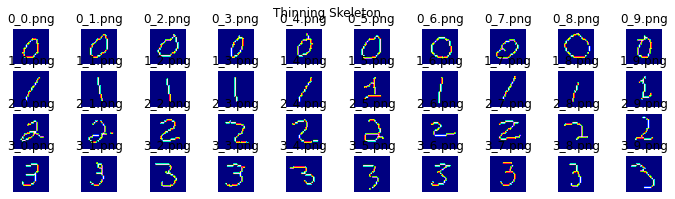

In [47]:
skeleton_zero=[]
median_skeleton_zero=[]
Binary=[]
for im, nm in zip(zeros_im, zeros_names):
    # Transforming image to binary image
    ret,thresh = cv2.threshold(im,230,255,cv2.THRESH_BINARY)
    np_img = np.array(thresh)
    np_img[np_img > 0] = 1
    # Skeletonizing the image
    skeleton_zero.append(skeletonize(np_img))

skeleton_one=[]
Binary=[]
for im, nm in zip(ones_im, ones_names):
    # Transforming image to binary image
    ret,thresh = cv2.threshold(im,230,255,cv2.THRESH_BINARY)
    np_img = np.array(thresh)
    np_img[np_img > 0] = 1
    # Skeletonizing the image
    skeleton_one.append(skeletonize(np_img))

skeleton_two=[]
Binary=[]
for im, nm in zip(twos_im, twos_names):
    # Transforming image to binary image
    ret,thresh = cv2.threshold(im,230,255,cv2.THRESH_BINARY)
    np_img = np.array(thresh)
    np_img[np_img > 0] = 1
    # Skeletonizing the image
    skeleton_two.append(skeletonize(np_img))
    
skeleton_three=[]
Binary=[]
for im, nm in zip(threes_im, threes_names):
    # Transforming image to binary image
    ret,thresh = cv2.threshold(im,230,255,cv2.THRESH_BINARY)
    np_img = np.array(thresh)
    np_img[np_img > 0] = 1
    # Skeletonizing the image
    skeleton_three.append(skeletonize(np_img))

# Plotting the skeletons
fig, axes = plt.subplots(4, len(zeros_im), figsize=(12, 3)) 
plt.suptitle('Thinning Skeleton')
for ax, im, nm in zip(axes[0], skeleton_zero, zeros_names):
    ax.imshow(im, cmap='gist_ncar')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], skeleton_one, ones_names):
    ax.imshow(im, cmap='gist_ncar')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[2], skeleton_two, twos_names):
    ax.imshow(im, cmap='gist_ncar')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[3], skeleton_three, threes_names):
    ax.imshow(im, cmap='gist_ncar')
    ax.axis('off')
    ax.set_title(nm)


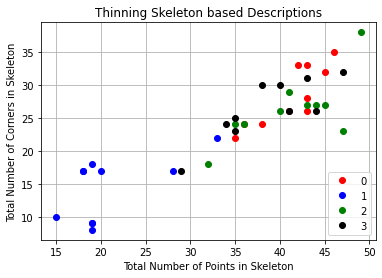

In [48]:
# Removing the first and last rows and columns from images
_,h,w= np.shape(skeleton_zero)
h=h-1
w=w-1
skeleton_zero_check=skeleton_zero[:][1:h][1:w]

# Initilizing the variables
Total_number_of_points0=[]
Total_number_of_corners0=[]

# Main for loop for feature extraction of zeros
for im in np.arange(0,np.shape(skeleton_zero)[0],1):
    Number_of_points=0
    Number_of_corners=0
    vertical_line=[]
    for x in np.arange(1,h,1):
        for y in np.arange(1,w,1):
            if skeleton_zero[im][x][y]==True:
                 # Extracting the number of points
                Number_of_points=Number_of_points+1
                s=0
                for a in np.arange(-1,1,1):
                    for b in np.arange(-1,1,1):
                        if skeleton_zero[im][x+a][y+b]== True:
                            s=s+1
                if s==2:
                    # Extracting the number of corners
                    Number_of_corners=Number_of_corners+1

    Total_number_of_points0.append(Number_of_points)
    Total_number_of_corners0.append(Number_of_corners)
    
# Removing the first and last rows and columns from images    
_,h,w= np.shape(skeleton_one)
h=h-1
w=w-1
skeleton_one_check=skeleton_one[:][1:h][1:w]

# Initilizing the variables
Total_number_of_points1=[]
Total_number_of_corners1=[]

# Main for loop for feature extraction of ones
for im in np.arange(0,np.shape(skeleton_one)[0],1):
    Number_of_points=0
    Number_of_corners=0
    for x in np.arange(1,h,1):
        for y in np.arange(1,w,1):
            if skeleton_one[im][x][y]==True:
                # Extracting the number of points
                Number_of_points=Number_of_points+1
                s=0
                for a in np.arange(-1,1,1):
                    for b in np.arange(-1,1,1):
                        if skeleton_one[im][x+a][y+b]== True:
                            s=s+1
                if s==2:
                    # Extracting the number of corners
                    Number_of_corners=Number_of_corners+1
    Total_number_of_points1.append(Number_of_points)
    Total_number_of_corners1.append(Number_of_corners) 
############################################################
# Removing the first and last rows and columns from images
_,h,w= np.shape(median_skeleton_two)
h=h-1
w=w-1
skeleton_two_check=median_skeleton_two[:][1:h][1:w]

# Initilizing the variables
Total_number_of_points2=[]
Total_number_of_corners2=[]

# Main for loop for feature extraction of twos
for im in np.arange(0,np.shape(median_skeleton_two)[0],1):
    Number_of_points=0
    Number_of_corners=0
    vertical_line=[]
    for x in np.arange(1,h,1):
        for y in np.arange(1,w,1):
            if median_skeleton_two[im][x][y]==True:
                 # Extracting the number of points
                Number_of_points=Number_of_points+1
                s=0
                for a in np.arange(-1,1,1):
                    for b in np.arange(-1,1,1):
                        if median_skeleton_two[im][x+a][y+b]== True:
                            s=s+1
                if s==2:
                    # Extracting the number of corners
                    Number_of_corners=Number_of_corners+1

    Total_number_of_points2.append(Number_of_points)
    Total_number_of_corners2.append(Number_of_corners)

############################################################
# Removing the first and last rows and columns from images
_,h,w= np.shape(median_skeleton_three)
h=h-1
w=w-1
skeleton_three_check=median_skeleton_three[:][1:h][1:w]

# Initilizing the variables
Total_number_of_points3=[]
Total_number_of_corners3=[]

# Main for loop for feature extraction of threes
for im in np.arange(0,np.shape(median_skeleton_three)[0],1):
    Number_of_points=0
    Number_of_corners=0
    vertical_line=[]
    for x in np.arange(1,h,1):
        for y in np.arange(1,w,1):
            if median_skeleton_three[im][x][y]==True:
                 # Extracting the number of points
                Number_of_points=Number_of_points+1
                s=0
                for a in np.arange(-1,1,1):
                    for b in np.arange(-1,1,1):
                        if median_skeleton_three[im][x+a][y+b]== True:
                            s=s+1
                if s==2:
                    # Extracting the number of corners
                    Number_of_corners=Number_of_corners+1

    Total_number_of_points3.append(Number_of_points)
    Total_number_of_corners3.append(Number_of_corners)


# Plotting the features plot
Plot_zeros = plt.plot(Total_number_of_points0,Total_number_of_corners0, "o", label="0", c='r')
Plot_ones = plt.plot(Total_number_of_points1,Total_number_of_corners1, "o", label="1", c='b')
Plot_twos = plt.plot(Total_number_of_points2, Total_number_of_corners2, "o", label="2", c='g')
Plot_threes = plt.plot(Total_number_of_points3, Total_number_of_corners3, "o", label="3", c='k')

plt.legend(loc=4)
plt.xlabel('Total Number of Points in Skeleton')
plt.ylabel('Total Number of Corners in Skeleton')
plt.title('Thinning Skeleton based Descriptions')
plt.grid(True)
plt.show()

The result shows that utilizing two introduced thinning skeleton based descriptors is insufficient to discriminater
 four numbers from each other


